In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.distributions import normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

from torchvision import datasets

In [ ]:
torchvision.datasets.MNIST('/drive/MyDrive/Experiments',download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /drive/MyDrive/Experiments/MNIST/raw/train-images-idx3-ubyte.gz to /drive/MyDrive/Experiments/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /drive/MyDrive/Experiments/MNIST/raw/train-labels-idx1-ubyte.gz to /drive/MyDrive/Experiments/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /drive/MyDrive/Experiments/MNIST/raw/t10k-images-idx3-ubyte.gz to /drive/MyDrive/Experiments/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /drive/MyDrive/Experiments/MNIST/raw/t10k-labels-idx1-ubyte.gz to /drive/MyDrive/Experiments/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /drive/MyDrive/Experiments
    Split: Train

In [ ]:
Transform = transforms.ToTensor()
train = datasets.MNIST(root='/drive/MyDrive/Experiments', train = True, download = False, transform = Transform)
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /drive/MyDrive/Experiments
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test = datasets.MNIST(root='/drive/MyDrive/Experiments', train = False, download = False, transform = Transform)
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: /drive/MyDrive/Experiments
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
from torch.utils.data import Dataset
class MNISTDataset(Dataset):
    """
    MAP-style. __getitem__ and __len__ methods need to be implemented.
    """
    def __init__(self, path, train): # train is a boolean
        Transform = transforms.ToTensor()
        data = datasets.MNIST(root=path, train = train, download = False, transform = Transform)
        self.images = [None] * len(data) #Holds the image pixel array
        self.labels = [None] * len(data) #Holds the number label
        for i in range(len(data)):
            self.images[i] = data[i][0]
            self.labels[i] = data[i][1]

    def __getitem__(self, index):
        x = self.images[index].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) # flatten the image from a 28 x 28 to a 784 1-dimensional tensor
        return x

    # returns the length of the dataset
    def __len__(self):
        return len(self.labels)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim = 128):
        super().__init__()

        # 2 layers for the encoder
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)

        # decoder
        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
    
    def forward(self, x):
        '''
        x is the input data
        returns the reconstruction
        '''
        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        return x_hat

    def run_encoder(self, x):
        output = F.relu(self.encoder_l1(x)) # relu adds non linearity
        latent = F.relu(self.encoder_l2(output)) # results in the latent vector
        return latent

    def run_decoder(self, latent):
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output))
        return x_hat

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim=2):
        super().__init__()
        self.latent_dim=latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=(int(input_shape/2))),
            nn.ReLU(),
            nn.Linear(in_features=(int(input_shape/2)), out_features=(int(input_shape/4))),
            nn.ReLU(),
            nn.Linear(in_features=(int(input_shape/4)), out_features=(int(input_shape/4))),
            nn.ReLU(),
            nn.Linear((int(input_shape/4)), (int(input_shape/8))),
        )

        
        self.fc_mu = nn.Linear((int(input_shape/8)), latent_dim) # Learn mu, means of normal distribution
        self.fc_log_var = nn.Linear((int(input_shape/8)), latent_dim) # Learn log variance, variances of normal distribution
        

        # decoder
        self.decoder = nn.Sequential(
              nn.Linear(in_features=latent_dim, out_features=(int(input_shape/4))),
              nn.ReLU(),
              nn.Linear(in_features=(int(input_shape/4)), out_features=(int(input_shape/4))),
              nn.ReLU(),
              nn.Linear(in_features=(int(input_shape/4)), out_features=(int(input_shape/2))),
              nn.ReLU(),
              nn.Linear(in_features=(int(input_shape/2)), out_features=input_shape)
        )

    # This should be fine
    def forward(self, x):
        '''
        x is the input data
        returns the reconstruction
        '''
        x = self.encoder(x) # Encodes the input
        mu, log_var = self.fc_mu(x), self.fc_log_var(x) # Get the mean and log_variance
        sample = self.reparameterize(mu, log_var) # Get a sample from the distribution
        reconstruction = self.decoder(sample)  # Decode the distribution sample
        return sample, mu, log_var, reconstruction

    def run_encoder(self, x):
        x = self.encoder(x) # Encodes the input into 
        mu, log_var = self.fc_mu(x), self.fc_log_var(x)
        sample = self.reparameterize(mu, log_var)
        return sample

    def reparameterize(self, mu, log_var):
        # x =mu+std*N(0,1) instead of x-N(mu, std) because of reparameterization trick
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # Need eps to be the same size
        sample = mu + (eps * std) # sampling
        return sample

    def generate(self, num_samples):
        rand_features = torch.randn(num_samples, self.latent_dim).cuda()
        generated = self.decoder(rand_features)
        return generated

In [ ]:
train_dataset = MNISTDataset('/drive/MyDrive/Experiments', True)
test_dataset = MNISTDataset('/drive/MyDrive/Experiments', False)

image_shape = train_dataset[0].shape[0] # Gets the shape of an image from the dataset. '.shape' has a [0] to get the integer from the tensor object
print(type(image_shape))

model = VariationalAutoEncoder(input_shape = image_shape)
model.cuda()

<class 'int'>


VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=196, bias=True)
    (5): ReLU()
    (6): Linear(in_features=196, out_features=98, bias=True)
  )
  (fc_mu): Linear(in_features=98, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=98, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=392, bias=True)
    (5): ReLU()
    (6): Linear(in_features=392, out_features=784, bias=True)
  )
)

In [ ]:
model.train() # Set to train() mode. There's also an eval() mode.

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=196, bias=True)
    (5): ReLU()
    (6): Linear(in_features=196, out_features=98, bias=True)
  )
  (fc_mu): Linear(in_features=98, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=98, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=196, bias=True)
    (1): ReLU()
    (2): Linear(in_features=196, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=392, bias=True)
    (5): ReLU()
    (6): Linear(in_features=392, out_features=784, bias=True)
  )
)

In [ ]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=128, #number of training samples to load in at a time
                                            shuffle=True) # Shuffle the data beforehand
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100

for epoch in range(n_epochs):
    loss = 0
    #Batch_features is each training batch. Here it's of the shape (128, 784).
    for batch_features in train_loader:
        batch_features = batch_features.cuda()

        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features) # Runs the forward function and gets outputs

        # compute the reconstruction loss of the training data
        train_loss = mse(outputs[3], batch_features)

        #compute accumulated gradients
        train_loss.backward() # Calculates the gradients

        # performs -parameter update- based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    #compute the epoch training loss
    loss = loss / len(train_loader)

    if epoch%5 ==0:
      print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))
print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))

epoch : 1/100, loss = 0.054386
epoch : 6/100, loss = 0.037962
epoch : 11/100, loss = 0.036356
epoch : 16/100, loss = 0.035777
epoch : 21/100, loss = 0.035070
epoch : 26/100, loss = 0.034631
epoch : 31/100, loss = 0.034225
epoch : 36/100, loss = 0.035154
epoch : 41/100, loss = 0.033962
epoch : 46/100, loss = 0.033958
epoch : 51/100, loss = 0.034242
epoch : 56/100, loss = 0.034337
epoch : 61/100, loss = 0.033573
epoch : 66/100, loss = 0.033942
epoch : 71/100, loss = 0.033898
epoch : 76/100, loss = 0.033735
epoch : 81/100, loss = 0.034687
epoch : 86/100, loss = 0.033702
epoch : 91/100, loss = 0.033597
epoch : 96/100, loss = 0.033518
epoch : 100/100, loss = 0.032832


Below, change the image_idx to a random image from the MNIST dataset. The top image is the VAE's reconstruction, below is the actual.

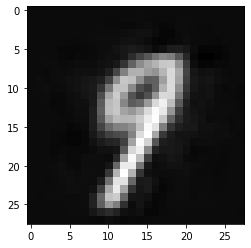

In [ ]:
# Put the model in eval mode. VAEs are pretty well known for their images being blurry
model.eval()

image_idx = 19

image = train_dataset[image_idx].cuda() # Get an image from the training dataset at index 100
x_hat = model(image) # Use the image in the model
x_hat = x_hat[3].detach().cpu().numpy().reshape((28,28)) # Take the model's output (The reconstruction is at index 3) and reshape it back into an image
plt.imshow(x_hat, cmap = 'gray') # Display the model's output

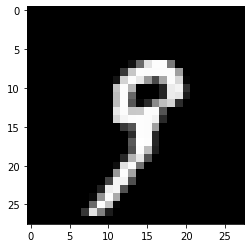

In [ ]:
plt.imshow(image.cpu().reshape((28,28)), cmap = 'gray') # Display the model's input

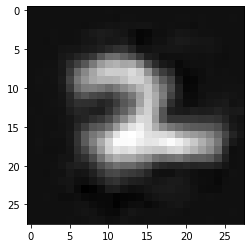

In [ ]:
# This runs the model's generate function, which takes a random sample from the distribution and attempts to turn it into an image

random = model.generate(1)
plt.imshow(random[0].detach().cpu().numpy().reshape((28,28)), cmap = 'gray') # Display the model's output

MIDI DATASET TRAINING

In [ ]:
pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 36.8 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=fe5f7ee51d04bd0b829e526bdbe012eb9b3355bc188fcf8499bd0aec8652e1be
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import torch
import pretty_midi
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np


def notes(pm):
    instrument = pm.instruments[0]
    notes = instrument.notes
    return notes

def notesToSample(noteslist, numNotes):
    #sample = pd.DataFrame({'start', 'end', 'pitch', 'velocity'})
    sample = np.zeros(shape=(4, numNotes))
    for i in range(numNotes):
        try:
            note = noteslist[i]
            sample[0][i]=(note.start)
            sample[1][i]=(note.end)
            sample[2][i]=(note.pitch)
            sample[3][i]=(note.velocity)
        except IndexError: # If the song doesn't have the correct amount of notes...just return an empty array of the correct size. 
            return np.zeros(shape=(4, numNotes))
    return sample

def sampleToMIDI(sample, filename):
    '''
    sample - note attributes in a tensor
    returns - prettyMIDI object
    '''
    instrument = pretty_midi.Instrument(0, is_drum=False) # Piano instrument
    pm = pretty_midi.PrettyMIDI()
    for i in range(sample.shape[1]):    
        start = float(sample[0][i])
        end = float(sample[1][i])
        pitch = int(sample[2][i])
        velocity = int(sample[3][i])
        instrument.notes.append(pretty_midi.Note(velocity, pitch, start, end))
    pm.instruments.append(instrument)
    pm.write(filename)
    return pm

from torch.utils.data import Dataset

class ImprovedPianoDataset(Dataset):
    def __init__(self, directory, numnotes): #notes is the number of notes from the file sampled, directory is location of midi files
        self.directory = directory
        self.numnotes = numnotes
        self.filenames = os.listdir(directory)

    def __getitem__(self, index):      
        file = self.filenames[index]
        f = os.path.join(self.directory, file) # Combines the directory and filename to get the filepath of the desired midi

        pm = pretty_midi.PrettyMIDI(f)
        note = notes(pm) # The notes from the midi file
        noteSample = notesToSample(note, self.numnotes) # convert the note to a sample of desired size

        x = torch.Tensor(noteSample)
        x = torch.flatten(x) # flatten to a 1-dimensional tensor to ready it for input into the model
        return x

    # returns the length of the dataset
    def __len__(self):
        return len(self.filenames)


In [ ]:

NoteCount = 25 # The amount of notes you want to sample from a song
# Full Giant MIDI dataset path: /content/drive/MyDrive/Project/maestro-v3.0.0/midis
# MAESTRO 2004 dataset path: /content/drive/MyDrive/Project/maestro-v3.0.0/2004
# MIDI File I'm slowly adding more data to: /content/drive/MyDrive/Project/maestro-v3.0.0/Growth
MIDIdataset = ImprovedPianoDataset('/content/drive/MyDrive/Project/Growth', NoteCount)


In [ ]:
inputShape = MIDIdataset[0].shape[0]
print("Input Shape: " + str(inputShape))
model = VariationalAutoEncoder(input_shape = inputShape, latent_dim=8)
model.cuda()

Input Shape: 100


VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=12, bias=True)
  )
  (fc_mu): Linear(in_features=12, out_features=8, bias=True)
  (fc_log_var): Linear(in_features=12, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=100, bias=True)
  )
)

In [ ]:
# Checking the data and dataset
print(MIDIdataset.__len__())
print(type(MIDIdataset)) #PianoDataset Object
print(type(MIDIdataset[0])) #Tensor object
print(MIDIdataset[0].shape)
#print(dataset[0])
sample = MIDIdataset[109].detach().cpu().numpy().reshape((4,NoteCount))
#print(sample)
midi = sampleToMIDI(sample, "SECONDMIDITEST.midi")


1276
<class '__main__.ImprovedPianoDataset'>
<class 'torch.Tensor'>
torch.Size([100])


In [ ]:
model.train()

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=12, bias=True)
  )
  (fc_mu): Linear(in_features=12, out_features=8, bias=True)
  (fc_log_var): Linear(in_features=12, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=100, bias=True)
  )
)

In [ ]:


MIDI_loader = torch.utils.data.DataLoader(MIDIdataset,
                                            batch_size=25, #number of training samples to load in at a time
                                            shuffle=True) # Shuffle the data beforehand
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10

for epoch in range(n_epochs):
    loss = 0
    #Batch_features is each training batch. Here it's of the shape (128, 784).
    for batch_features in MIDI_loader:
        batch_features = batch_features.cuda()

        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features) # Runs the forward function and gets outputs

        # compute the reconstruction loss of the training data
        train_loss = mse(outputs[3], batch_features)

        #compute accumulated gradients
        train_loss.backward() # Calculates the gradients

        # performs -parameter update- based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    #compute the epoch training loss
    loss = loss / len(train_loader)

    if epoch%5 ==0:
      print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))
print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))

epoch : 1/10, loss = 210.333463
epoch : 6/10, loss = 11.292733
epoch : 10/10, loss = 11.124821


In [ ]:
model.eval()

midi_idx = 19

midi = MIDIdataset[midi_idx].cuda() # Get a midi file from the dataset
x_hat = model(midi)[3] # Get the reconstruction

sample = MIDIdataset[midi_idx].detach().cpu().numpy().reshape((4,NoteCount)) # Reforms the sample into the proper shape for MIDI transformation
sampleToMIDI(sample, "input.midi")
x_hat = x_hat.detach().cpu().numpy().reshape((4,NoteCount))
sampleToMIDI(x_hat, "reformed.midi")


In [ ]:
# Generate a MIDI sample
for i in range(5):
    random = model.generate(1)
    random = random.detach().cpu().numpy().reshape((4,NoteCount))
    sampleToMIDI(random, str(i)+"generated.midi")
